In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

Using the manual ZP file ... .


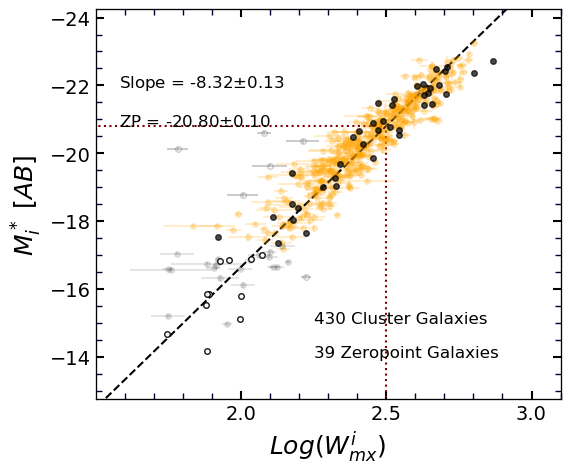

In [5]:
band = 'i'

ctl   = np.genfromtxt('allzpa_labels.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dm19']-25)/5)  
manualInput_all = (PGC,ID,dist)

ctl   = np.genfromtxt('TFcal_ZP_trgb2.81.rizzi.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dmtriz']-25)/5) 
manualInput_rizzi = (PGC,ID,dist)



ctl   = np.genfromtxt('TFcal_ZP_cepheids2.33.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dmc19']-25)/5) 
manualInput_cepheids = (PGC,ID,dist)


manualInput = manualInput_all

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = False,
                                            manualInput=manualInput
                                           )

In [6]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

print S_ZP

Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)

[-8.318095713582585 0.1320687513953603 -20.803958248826735
 array([0.09867064])]


[5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
[3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073, 3974, 19871, 22277, 38148, 41020, 41093, 46127]


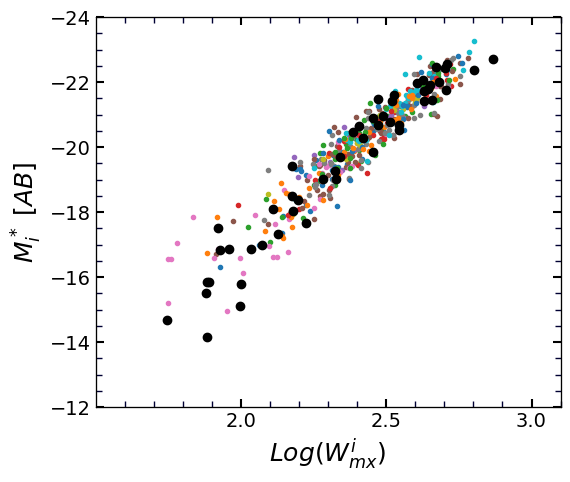

In [7]:
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)

# I_maglim = []

for i, key in enumerate(Clusters):
    myCluster = Clusters[key]
    zp_ = myCluster['zp']
    zp    = zp_calibs['zp']
    pgc = myCluster['pgc']
    pgc_w = myCluster['pgc_w']
    mag_      = myCluster['mag']
    mag_w     = myCluster['mag_w']
    logWimx_  = myCluster['logWimx']
    offset=zp_-zp
    ax.errorbar(logWimx_, mag_-offset, fmt='.')
    
    for i, idd in enumerate(pgc):
        m = mag_[i]
        if m-offset > -17.:
            if not pgc[i] in I_maglim:
                I_maglim.append(pgc[i])
    for i, idd in enumerate(pgc_w):
        m = mag_w[i]
        if m-offset > -17.:
            if not pgc_w[i] in I_maglim:
                I_maglim.append(pgc_w[i])
                
print I_maglim


# calib_maglim = []
pgc = zp_calibs['pgc']
pgc_w = zp_calibs['pgc_w']
mag_      = zp_calibs['MAG']
mag_w     = zp_calibs['MAG_w']
logWimx_  = zp_calibs['logWimx']
ax.errorbar(logWimx_, mag_, fmt='o', color='black')

for i, idd in enumerate(pgc):
    m = mag_[i]
    if m > -16.1:
        if not pgc[i] in I_maglim:
            calib_maglim.append(pgc[i])
for i, idd in enumerate(pgc_w):
    m = mag_w[i]
    if m > -16.1:
        if not pgc_w[i] in I_maglim:
            calib_maglim.append(pgc_w[i])
            
print calib_maglim

In [8]:
d_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        print key, myCluster['slope'], myCluster['zp'], Clusters_orig[key]['zp']-zp, Clusters_orig[key]['name']
        
        d_modulus = Clusters_orig[key]['zp']-zp
        d_lst.append(d_modulus)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, '%.1f'%d_lst[i], Clusters_orig[key]['name']

NEST_200092 -8.318095713582585 12.400707419532443 33.04346445367235 Pegasus
NEST_200037 -8.318095713582585 13.712721629727584 34.58561934632213 NGC70
NEST_200005 -8.318095713582585 13.14420643813248 33.95291049239927 NGC410
NEST_200006 -8.318095713582585 13.059917304138544 33.859056794813625 NGC507
NEST_200012 -8.318095713582585 13.995017687013172 34.794387893135294 Abell 400
NEST_100001 -8.318095713582585 13.94783934119305 34.74641179137957 Coma
NEST_100002 -8.318095713582585 10.027362663553445 30.93622478323767 Virgo
NEST_100005 -8.318095713582585 13.914319430742253 34.71608105055442 Abell 1367
NEST_200045 -8.318095713582585 13.68798438060228 34.513604007254 NGC80
NEST_100007 -8.318095713582585 15.069341753098263 35.86415011788439 Abell 2151 (Hercules)
NEST_200016 -8.318095713582585 14.413717681105148 35.231357327519916 Abell 2634/66
NEST_100008 -8.318095713582585 10.434425530927284 31.233604838892965 Ursa Major
NEST_100030 -8.318095713582585 13.291872452284585 34.09332980415974 Canc

In [9]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

Virgo (24) -7.36 0.44 10.13 0.09 10.03 0.09 0.69


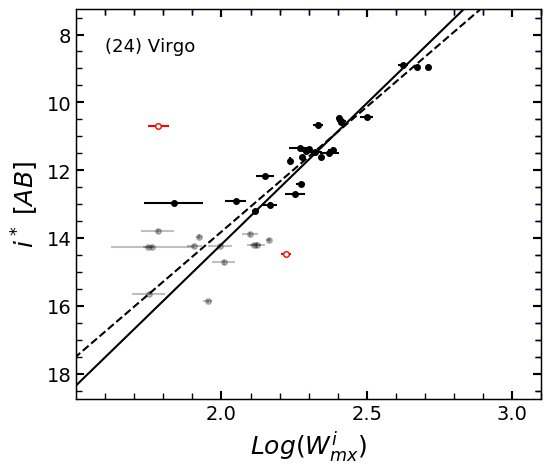

In [10]:
##########################################
def plotSingleCluster(key, xLim = (1.5,3.1), yLim = (18.75,7.25)):
#         key = 'NEST_100002'
    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color='k', 
                        alphaFaint=0.25, weirdColor='r', alphaWeird=1.)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(2, 3.5, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')   
        x_ax.set_xticks(np.arange(2, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
##########################################    
    
    

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25))
plotSingleCluster('NEST_100002')

Virgo (24) -7.36 0.44 10.13 0.09 10.03 0.09 0.69
Ursa Major (36) -8.39 0.46 10.43 0.08 10.43 0.07 0.53
Pegasus (24) -9.27 1.15 12.24 0.23 12.40 0.11 0.59
NGC507 (20) -7.27 0.57 13.06 0.10 13.06 0.12 0.53
NGC410 (33) -8.10 0.58 13.15 0.08 13.14 0.08 0.52
Cancer (18) -8.15 0.82 13.29 0.11 13.29 0.11 0.48
NGC80 (14) -7.29 0.54 13.71 0.06 13.69 0.07 0.41
NGC70 (11) -9.32 1.26 13.78 0.15 13.71 0.10 0.35
Abell 1367 (68) -8.40 0.44 13.91 0.06 13.91 0.06 0.56
Coma (79) -8.68 0.40 13.94 0.06 13.95 0.06 0.56
Abell 400 (21) -7.95 0.48 13.99 0.06 14.00 0.06 0.57
NGC4065 (14) -8.51 0.50 14.25 0.09 14.26 0.08 0.40
Abell 2634/66 (29) -8.48 0.64 14.43 0.09 14.41 0.06 0.48
Abell 2151 (Hercules) (39) -8.20 0.49 15.06 0.07 15.07 0.06 0.42


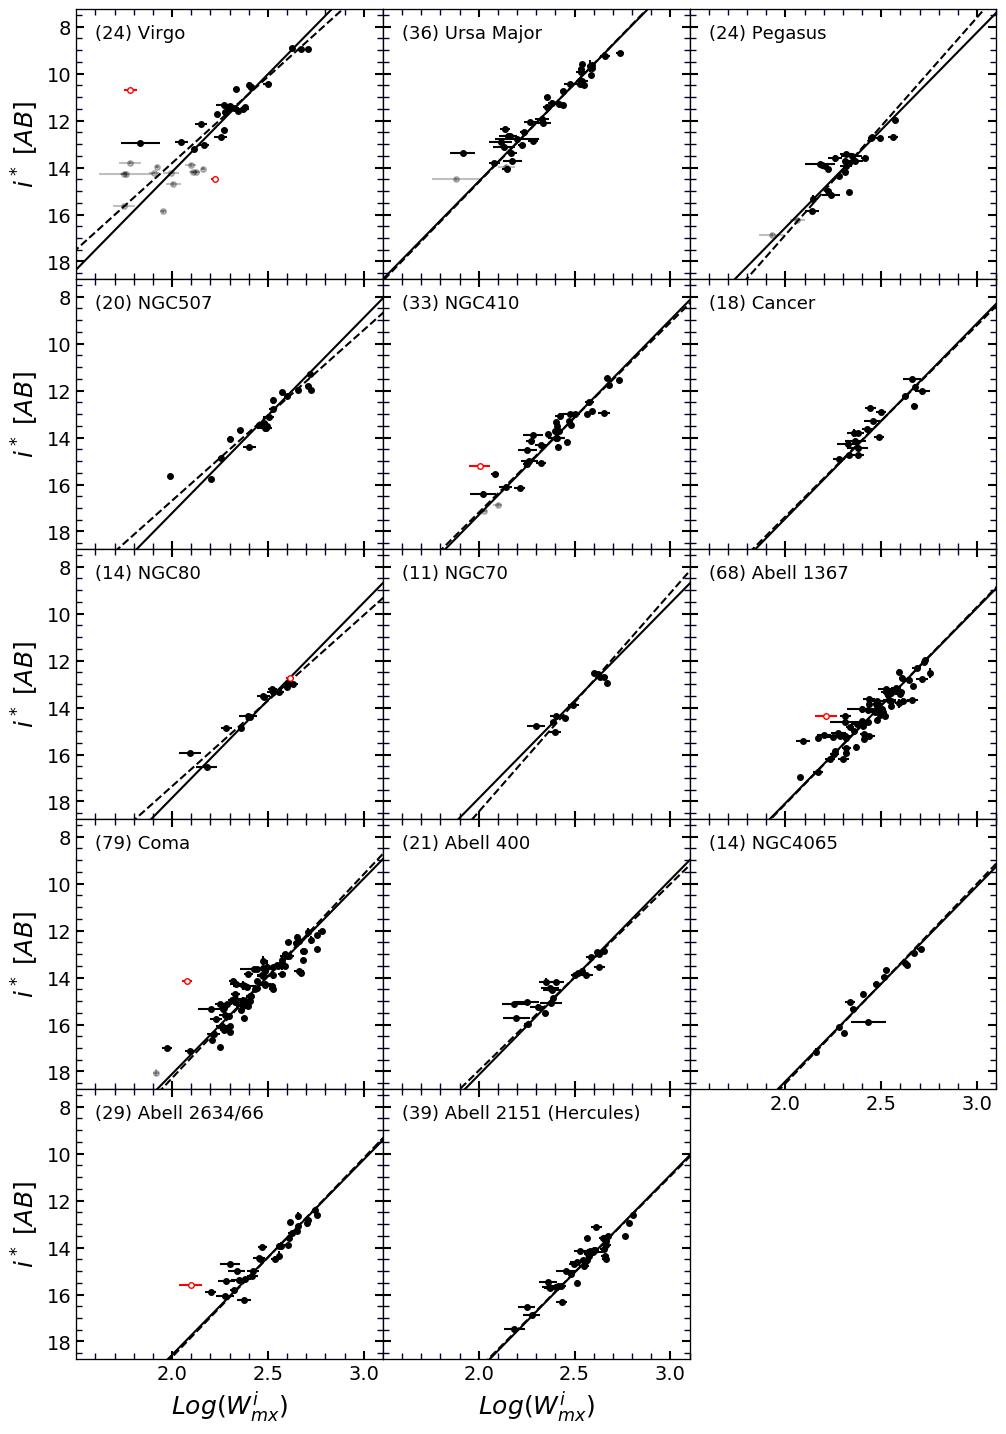

In [11]:
fig = py.figure(figsize=(10, 15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(5, 3); p=0

n = 0 
for i in indx:
    n+=1
    
    if True: #n<=3 or n>9:
    
        key = keys[i]
        ax = plt.subplot(gs[p])
        plotSingleCluster(key)

        if p%3==0: 
            ax.set_ylabel(r'$'+band+'^* \/\/ [AB]$', fontsize=18)
        else:
            plt.setp(ax.get_yticklabels(), visible=False) 

        if p>11: ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
        p+=1

plt.subplots_adjust(hspace=.0, wspace=0)

In [12]:
names  = []
pgcs = []

for key in Clusters:
    
    print 
    for idd in Clusters[key]['pgc']:
        if not idd in I_maglim and not idd in Clusters[key]['pgc_w']:
            pgcs.append(idd)
            names.append(Clusters[key]['name'])
            
myTable = Table()
myTable.add_column(Column(data=pgcs, name='pgc'))
myTable.add_column(Column(data=names, name='Cluster'))

myTable.write('Clusters_i.csv', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True) 

In [13]:
# symcol = {}
# symcol['V']  = 'black'
# symcol['U']  = 'blue'
# symcol['F']  = 'green'
# symcol['Ce'] = 'dodgerblue'
# symcol['An'] = 'olive'
# symcol['Pe'] = 'darkgreen'
# symcol['Hy'] = 'm'
# symcol['A2'] = 'darkgoldenrod'
# symcol['N41'] = 'orchid'
# symcol['N5'] = 'firebrick'
# symcol['Ca'] = 'sienna'
# symcol['N8'] = 'slateblue'
# symcol['N7'] = 'chocolate'
# symcol['A1'] = 'red'
# symcol['Co'] = 'maroon'
# symcol['A4'] = 'deeppink'
# symcol['N40']= 'magenta'
# symcol['A5'] = 'crimson'
# symcol['A26'] = 'purple'
# symcol['He'] = 'indigo'

symcol = {}
symcol['NEST_100002']=['Virgo', '*', 'black']
symcol['NEST_100008']=['UMa', '^', 'blue']
symcol['NEST_200015']=['Fornax', 's', 'green']
symcol['NEST_100003']=['Centaurus', 'D', 'dodgerblue']
symcol['NEST_100014']=['Antlia', '.', 'olive']
symcol['NEST_200092']=['Pegasus', '*', 'darkgreen']
symcol['NEST_100006']=['Hydra', '^', 'm']
symcol['NEST_200003']=['A262', 's', 'darkgoldenrod']
symcol['NEST_200005']=['N410', '*', 'orchid']
symcol['NEST_200006']=['N507', '.', 'firebrick']
symcol['NEST_100030']=['Cancer', '.', 'sienna']
symcol['NEST_200045']=['N80', '*', 'slateblue']
symcol['NEST_200037']=['N70', '.', 'chocolate']
symcol['NEST_100005']=['A1367', 's', 'red']
symcol['NEST_100001']=['Coma', '*', 'maroon']
symcol['NEST_200012']=['A400', 'D', 'deeppink']
symcol['NEST_100018']=['N4065', '*', 'magenta']
symcol['NEST_200017']=['A539', 's', 'crimson']
symcol['NEST_200016']=['A2634/66', '^', 'purple']
symcol['NEST_100007']=['Hercules', 'D', 'indigo']
def getVmod(key):

    if key == 'NEST_100002':  # Virgo
        return 1516., 45.
    if key == 'NEST_100008':  # U Ma
        return 1141., 13.
    if key == 'NEST_200015':  # Fornax
        return 1383., 32. 
    if key == 'NEST_200092':  # Pegasus
        return 3249., 61.
    if key == 'NEST_100003':  # Centaurus
        return 3645., 56.    
    if key == 'NEST_100014':  # Antlia
        return 3103., 53.
    if key == 'NEST_100006':  # Hydra
        return 4084., 44.    
    if key == 'NEST_200003':  # A 262
        return 4684., 50.
    if key == 'NEST_200006':  # N 507
        return 4660., 64.      
    if key == 'NEST_200005':  # N 410
        return 4792., 53.
    if key == 'NEST_100030':  # Cancer
        return 5025., 71.    
    if key == 'NEST_200045':  # N 80
        return 5499., 42. 
    if key == 'NEST_200037':  # N 70
        return 6619., 80.     
    if key == 'NEST_100005':  # A 1367
        return 7060., 61.    
    if key == 'NEST_100001':  # Coma
        return 7352., 70.
    if key == 'NEST_200012':  # A 400
        return 7357., 85. 
    if key == 'NEST_100018':  # N 4065
        return 7501., 63.
    if key == 'NEST_200017':  # A 539
        return 8995., 87.
    if key == 'NEST_200016':  # A 2634/66
        return 8954., 98.
    if key == 'NEST_100007':  # Hercules
        return 11353., 121.      

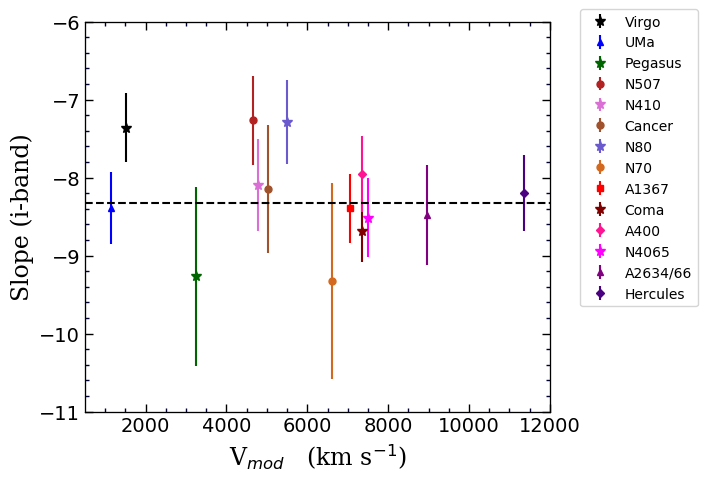

In [14]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
    
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


for i in indx:
    key = keys[i]
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    name = Clusters_orig[key]['name']
    code = Clusters_orig[key]['code']
    Vmod, Vmod_e = getVmod(key)
#     print name, Sorig, Sorig_e, Vmod, Vmod_e
    if Sorig!=0:
        
        
        if symcol[key][1]=='*':
                size = 7
        elif symcol[key][1]=='D':
                size = 4    
        elif symcol[key][1]=='s':
                size = 4           
        elif symcol[key][1]=='^':
                size = 5   
        elif symcol[key][1]=='.':
                size = 10          
        
        
        
        ax.errorbar(Vmod, Sorig, yerr=Sorig_e, fmt=symcol[key][1], color=symcol[key][2], ms=size, label=symcol[key][0])


        

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
        
ax.set_xlabel('V'+r'$_{mod}$'+'   (km s'+r'$^{-1}$'+')', fontsize=17, fontdict=font)
ax.set_ylabel('Slope (i-band)', fontsize=17, fontdict=font)
x_ax, y_ax = set_axes(ax, (500, 12000), (-11,-6), fontsize=14)


ax.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
ax.plot([500, 12000],[-8.32,-8.32], 'k--')

In [15]:
myKeys = ['NEST_100002', 'NEST_100008', 'NEST_200092',  'NEST_200005', 'NEST_200006', 'NEST_100030', 'NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012', 'NEST_100018', 'NEST_200016', 'NEST_100007']

for key in myKeys:
    myCluster = Clusters[key]
    
    mag = myCluster['mag']
    pgc = myCluster['pgc']
    ix = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            ix.append(i)  
    
    mags = mag[ix]
    jj = np.argsort(mags)
    
    print mags[jj][::-1][1]
    

    

13.03
13.81
15.33
16.14
15.65
14.75
15.94
14.8
16.74
17.02
15.72
16.34
16.05
16.89


Using the manual ZP file ... .


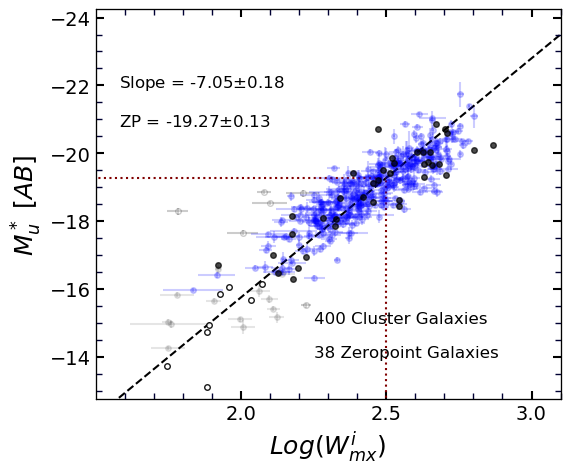

In [16]:
band = 'u'

fig, ax, u_Clusters, S_ZP, u_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


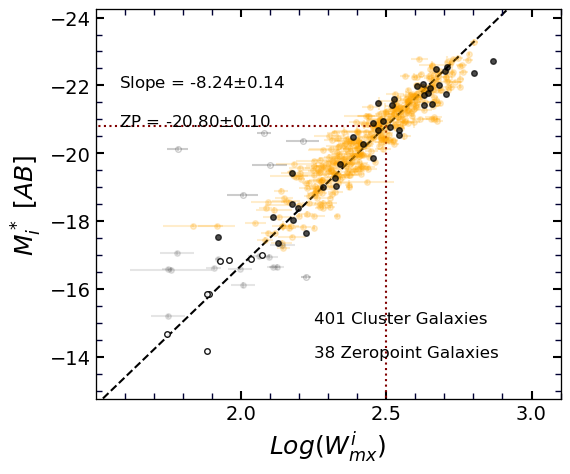

In [17]:
band = 'i'

fig, ax, i_Clusters, S_ZP, i_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


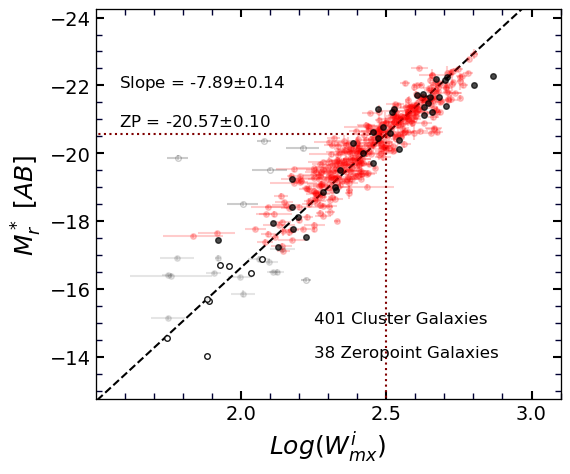

In [18]:
band = 'r'

fig, ax, r_Clusters, S_ZP, r_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


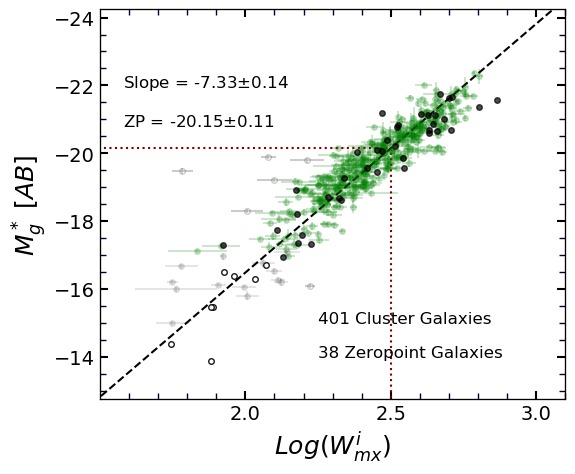

In [19]:
band = 'g'

fig, ax, g_Clusters, S_ZP, g_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


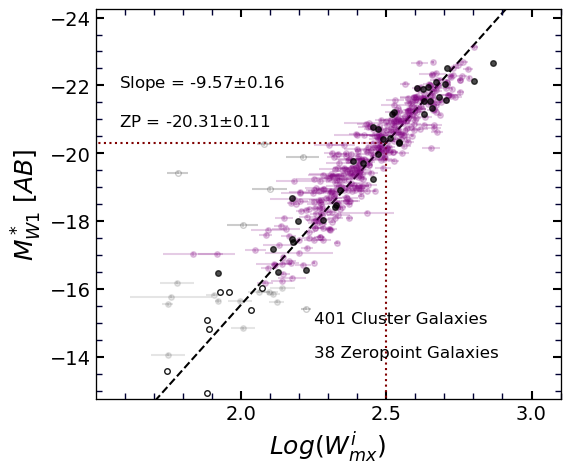

In [20]:
band = 'w1'

fig, ax, w1_Clusters, S_ZP, w1_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


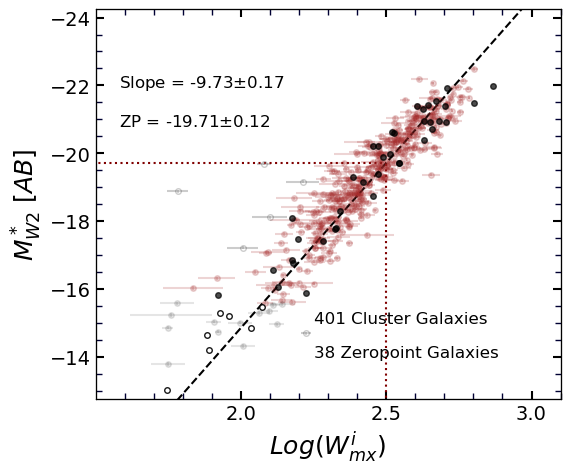

In [21]:
band = 'w2'

fig, ax, w2_Clusters, S_ZP, w2_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


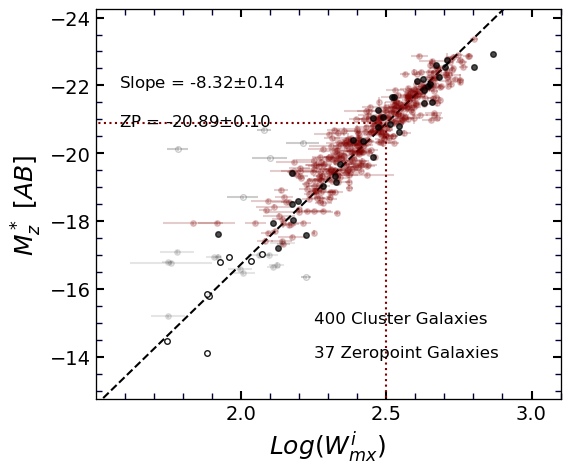

In [22]:
band = 'z'

fig, ax, z_Clusters, S_ZP, z_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

In [23]:
colorD = {}
for key in w1_Clusters:
    
    cluster = w1_Clusters[key]
    d_modulus = cluster['zp']-w1_zp_calibs['zp']
    
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd] = {}
        colorD[idd]['w1'] = cluster['mag'][j]
        colorD[idd]['logWimx'] = cluster['logWimx'][j]
        colorD[idd]['Mw1'] = cluster['mag'][j]-d_modulus
        
        
    
for key in i_Clusters:
    
    cluster = i_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['i'] = cluster['mag'][j]
        
for key in g_Clusters:
    
    cluster = g_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['g'] = cluster['mag'][j]  
        
for key in w2_Clusters:
    
    cluster = w2_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['w2'] = cluster['mag'][j]          

        
for key in z_Clusters:
    
    cluster = z_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['z'] = cluster['mag'][j]         

for key in r_Clusters:
    
    cluster = r_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['r'] = cluster['mag'][j]  
        
for key in u_Clusters:
    
    cluster = u_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['u'] = cluster['mag'][j]  
        
################################################
colorZ = {}

cluster = w1_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd] = {}
    colorZ[idd]['w1'] = cluster['mag'][j]
    colorZ[idd]['Mw1'] = cluster['MAG'][j]
    colorZ[idd]['logWimx'] = cluster['logWimx'][j]

cluster = i_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['i'] = cluster['mag'][j]

cluster = g_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['g'] = cluster['mag'][j]    

cluster = w2_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['w2'] = cluster['mag'][j]   
    
cluster = z_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['z'] = cluster['mag'][j]  
    
cluster = r_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['r'] = cluster['mag'][j]  
        
cluster = u_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['u'] = cluster['mag'][j]  

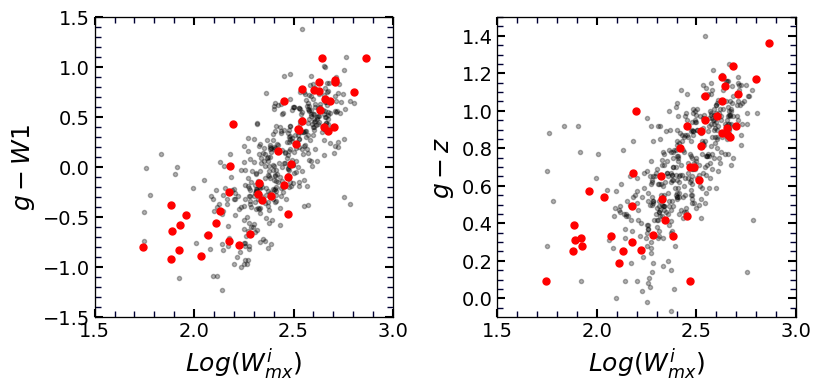

In [24]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0

##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['g']-colorD[key]['w1']
    ax.plot(logW, i_w1, 'k.', alpha=0.3)
    C_col.append(i_w1)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['g']-colorZ[key]['w1']
    ax.plot(logW, i_w1, 'r.', ms=10)
    Z_col.append(i_w1)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$g-W1$', fontsize=18)

xLim= [1.5,3]
yLim= [-1.5,1.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(1.5, 3.5, step=0.5))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    x_ax.set_xticks(np.arange(1.5, 3.5, step=0.5))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['g']-colorD[key]['z']
        ax.plot(logW, i_w1, 'k.', alpha=0.3)
        C_col.append(i_w1)
    except:
        pass

Z_col = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['g']-colorZ[key]['z']
        ax.plot(logW, i_w1, 'r.', ms=10)
        Z_col.append(i_w1)
    except:
        pass

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$g-z$', fontsize=18)

xLim= [1.5,3]
yLim= [-0.1,1.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(1.5, 3.5, step=0.5))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    x_ax.set_xticks(np.arange(1.5, 3.5, step=0.5))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
plt.subplots_adjust(hspace=0, wspace=0.35)

-0.53 -0.57


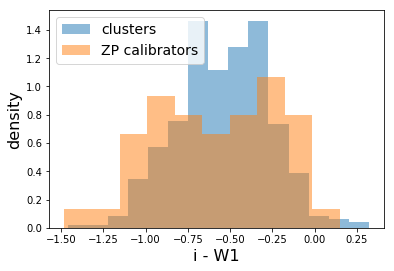

In [25]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['i']-colorD[key]['w1']
    ax.plot(logW, i_w1, 'k.', alpha=0.3)
    C_col.append(i_w1)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['i']-colorZ[key]['w1']
    ax.plot(logW, i_w1, 'r.', ms=10)
    Z_col.append(i_w1)

plt.hist(C_col, bins=15, alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=10, alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('i - W1', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

0.10 0.02


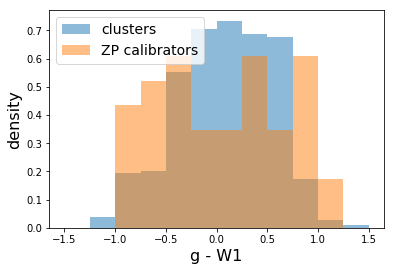

In [26]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    g_w1 = colorD[key]['g']-colorD[key]['w1']
    C_col.append(g_w1)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    g_w1 = colorZ[key]['g']-colorZ[key]['w1']
    Z_col.append(g_w1)
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-1.5,1.5,13), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-1.5,1.5,13), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('g - W1', fontsize=16)
plt.ylabel('density', fontsize=16)


print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

0.62 0.60


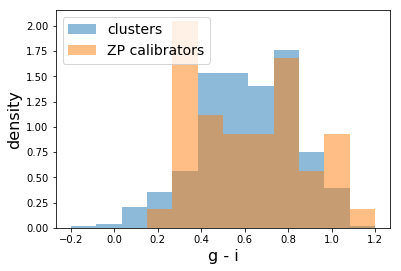

In [27]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    g_i = colorD[key]['g']-colorD[key]['i']
    C_col.append(g_i)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    g_i = colorZ[key]['g']-colorZ[key]['i']
    Z_col.append(g_i)
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-0.2,1.2,13), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-0.2,1.2,13), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('g - i', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

0.72 0.67


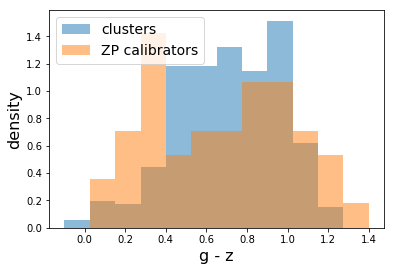

In [28]:
C_col = []
for key in colorD:
    try: 
        logW = colorD[key]['logWimx']
        g_z = colorD[key]['g']-colorD[key]['z']
        C_col.append(g_z)
    except:
        pass

Z_col = []
for key in colorZ:
    try: 
        logW = colorZ[key]['logWimx']
        g_z = colorZ[key]['g']-colorZ[key]['z']
        Z_col.append(g_z)
    except:
        pass
    
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-0.1,1.4,13), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-0.1,1.4,13), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('g - z', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

-0.58 -0.61


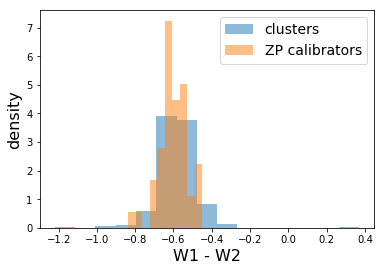

In [29]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    w1_w2 = colorD[key]['w1']-colorD[key]['w2']
    C_col.append(w1_w2)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    w1_w2 = colorZ[key]['w1']-colorZ[key]['w2']
    Z_col.append(w1_w2)
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=15, alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=10, alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('W1 - W2', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

# print len(C_col), len(Z_col)
# print Z_col
# print C_col[0:10]

-0.63 -0.62


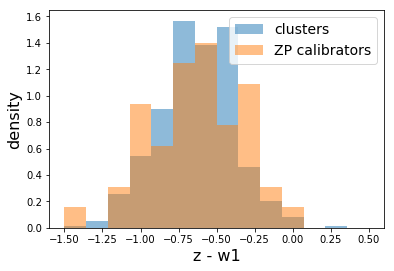

In [30]:
C_col = []
for key in colorD:
    try: 
        logW = colorD[key]['logWimx']
        g_z = colorD[key]['z']-colorD[key]['w1']
        C_col.append(g_z)
    except:
        pass

Z_col = []
for key in colorZ:
    try: 
        logW = colorZ[key]['logWimx']
        g_z = colorZ[key]['z']-colorZ[key]['w1']
        Z_col.append(g_z)
    except:
        pass
    
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-1.5,0.5,15), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-1.5,0.5,15), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('z - w1', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

[[0.00021623 0.00430816]
 [0.00430816 0.08630597]]
-6.038316446045356 0.29377878213565256
-5.94898436484181 0.07409532970623303
-0.08933208120354585 0.3029786968045486
[[7.68454809e-05 1.52133640e-03]
 [1.52133640e-03 3.03217492e-02]]
-4.363589117439476 0.17413141355810294
-4.251882650509906 0.0453621306561246
-0.11170646692957042 0.17994296898019216
[[3.94691188e-05 7.81383708e-04]
 [7.81383708e-04 1.55737553e-02]]
-3.572345361443518 0.12479485278410807
-3.4933924030327037 0.031535710275816906
-0.0789529584108144 0.1287177388863224
[[2.68466261e-05 5.31491880e-04]
 [5.31491880e-04 1.05931623e-02]]
-3.13651162323991 0.10292308928029247
-3.0913827425706617 0.02712104413372939
-0.04512888066924825 0.10643642864124458
[[2.63908533e-05 5.22352126e-04]
 [5.22352126e-04 1.04086599e-02]]
-2.9856165935702794 0.10202284030372334
-2.911768276540029 0.026716212592196396
-0.07384831703025041 0.10546286530770188
[[1.04345779e-05 2.06576925e-04]
 [2.06576925e-04 4.11728381e-03]]
-0.7556991833232942 

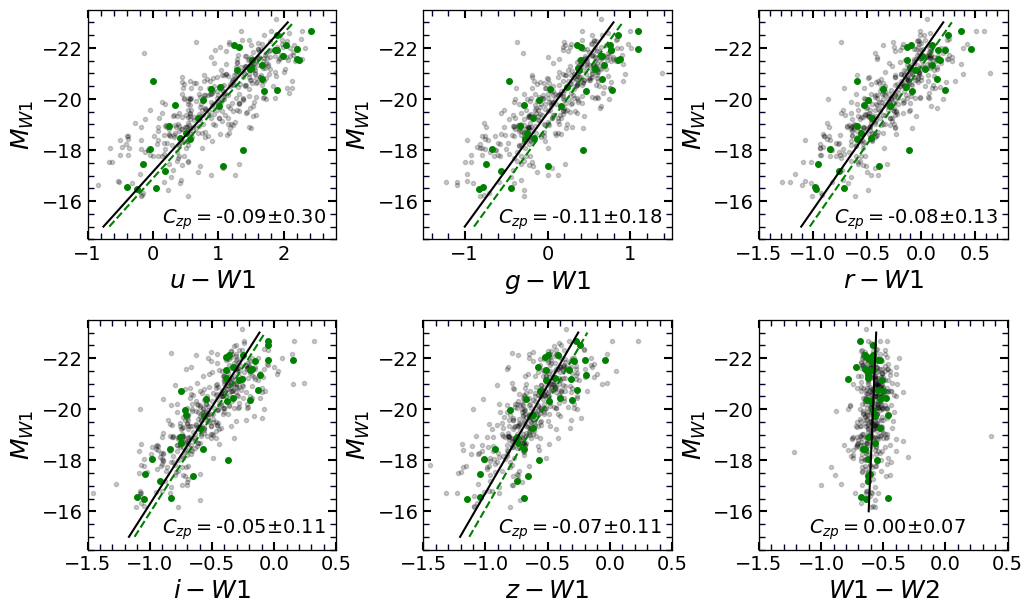

In [31]:
fig = py.figure(figsize=(10, 6), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(2, 3); p=0

##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['u']-colorD[key]['w1']
#         ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['u']-colorZ[key]['w1']
#         ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)

indx, = np.where(C_w<-16.1)
C_w = C_w[indx]
C_col = C_col[indx]

indx, = np.where(Z_w<-16.1)
Z_w = Z_w[indx]
Z_col = Z_col[indx]

ax.plot(C_col, C_w, '.', alpha=0.2, color='k')
ax.plot(Z_col, Z_w, 'g.', ms=8)

fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-15.0,-23,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '--', color='g')

delta =  b-b0
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$u-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.0,2.8]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1, 3., step=1))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.7*Xlm[0]+0.3*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, r"$C_{zp}=$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=14, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  
##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['g']-colorD[key]['w1']
#         ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['g']-colorZ[key]['w1']
#         ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)

indx0, = np.where(C_w<-16.1)
indx1, = np.where(Z_w<-16.1)

ax.plot(C_col[indx0], C_w[indx0], '.', alpha=0.2, color='k')
ax.plot(Z_col[indx1], Z_w[indx1], 'g.', ms=8)

fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-15.0,-23,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '--', color='g')

delta =  b-b0
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$g-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,1.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1., 1.5, step=1))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.7*Xlm[0]+0.3*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, r"$C_{zp}=$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=14, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  
##################################################################
# plt.title("Comparing all ZPa calibrators and cluster galaxies")
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['r']-colorD[key]['w1']
#         ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['r']-colorZ[key]['w1']
#         ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)

indx0, = np.where(C_w<-16.1)
indx1, = np.where(Z_w<-16.1)

ax.plot(C_col[indx0], C_w[indx0], '.', alpha=0.2, color='k')
ax.plot(Z_col[indx1], Z_w[indx1], 'g.', ms=8)

fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-15.0,-23,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '--', color='g')

delta =  b-b0
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$r-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,.8]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.7*Xlm[0]+0.3*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, r"$C_{zp}=$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=14, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  
##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['i']-colorD[key]['w1']
#     ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
    C_col.append(i_w1)
    C_w.append(colorD[key]['Mw1'])

Z_col = []
Z_w = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['i']-colorZ[key]['w1']
#     ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
    Z_col.append(i_w1)
    Z_w.append(colorZ[key]['Mw1'])


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)

indx0, = np.where(C_w<-16.1)
indx1, = np.where(Z_w<-16.1)

ax.plot(C_col[indx0], C_w[indx0], '.', alpha=0.2, color='k')
ax.plot(Z_col[indx1], Z_w[indx1], 'g.', ms=8)

fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-15.0,-23,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '--', color='g')

delta =  b-b0
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.7*Xlm[0]+0.3*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, r"$C_{zp}=$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=14, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  
##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['z']-colorD[key]['w1']
#         ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['z']-colorZ[key]['w1']
#         ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)

indx0, = np.where(C_w<-16.1)
indx1, = np.where(Z_w<-16.1)

ax.plot(C_col[indx0], C_w[indx0], '.', alpha=0.2, color='k')
ax.plot(Z_col[indx1], Z_w[indx1], 'g.', ms=8)

fit, cov = curve_fit(linfit, C_w, C_col)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-15.0,-23,20)
ax.plot(m*y+b, y, '-', color='black')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '--', color='green')

delta =  b-b0
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$z-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.7*Xlm[0]+0.3*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, r"$C_{zp}=$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=14, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['w1']-colorD[key]['w2']
#         ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['w1']-colorZ[key]['w2']
#         ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)

indx0, = np.where(C_w<-16.1)
indx1, = np.where(Z_w<-16.1)

ax.plot(C_col[indx0], C_w[indx0], '.', alpha=0.2, color='k')
ax.plot(Z_col[indx1], Z_w[indx1], 'g.', ms=8)

fit, cov = curve_fit(linfit, C_w, C_col)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-16.0,-23,20)
ax.plot(m*y+b, y, '-', color='black')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
# ax.plot(m*y+b0, y, '--', color='green')

delta =  b-b0
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$W1-W2$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.8*Xlm[0]+0.2*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, r"$C_{zp}=$"+"%.2f" % np.abs(delta*0.)+'$\pm$'+"%.2f" % delta_e, fontsize=14, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')   

##################################################################
plt.subplots_adjust(hspace=0.35, wspace=0.35)



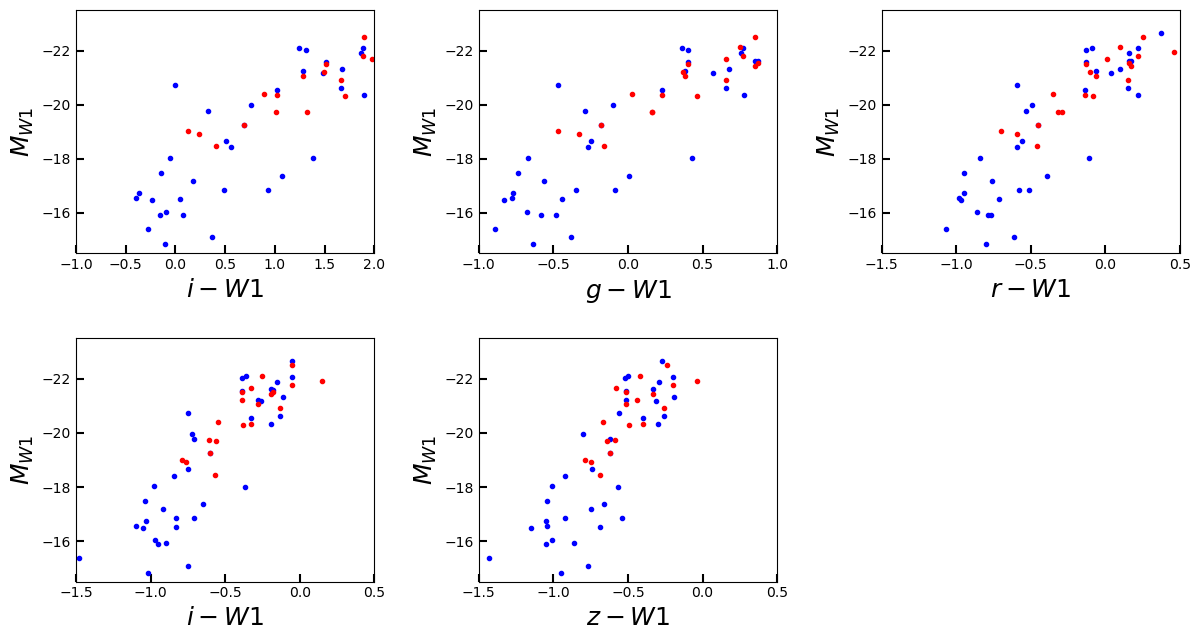

In [32]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0
ax = plt.subplot(gs[p]); p+=1 


ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
u    = ctl['u']
W1   = ctl['W1']

indx, = np.where(u>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(u-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
u    = ctl['u']
W1   = ctl['W1'] 
indx, = np.where(u>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(u-W1, W1-DM, 'r.')


ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.0,2.0]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')


########################################################################################

ax = plt.subplot(gs[p]); p+=1 



ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
g    = ctl['g']
W1   = ctl['W1']

indx, = np.where(g>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(g-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
g    = ctl['g']
W1   = ctl['W1'] 
indx, = np.where(g>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(g-W1, W1-DM, 'r.')


ax.set_xlabel(r'$g-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.,1.]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
########################################################################################

ax = plt.subplot(gs[p]); p+=1 

ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
r    = ctl['r']
W1   = ctl['W1']

indx, = np.where(r>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(r-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
r    = ctl['r']
W1   = ctl['W1'] 
indx, = np.where(r>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(r-W1, W1-DM, 'r.')


ax.set_xlabel(r'$r-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
########################################################################################
ax = plt.subplot(gs[p]); p+=1 

ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
i    = ctl['i']
W1   = ctl['W1']

indx, = np.where(i>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(i-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
i    = ctl['i']
W1   = ctl['W1'] 
indx, = np.where(i>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(i-W1, W1-DM, 'r.')


ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
########################################################################################

ax = plt.subplot(gs[p]); p+=1 
ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
z    = ctl['z']
W1   = ctl['W1']

indx, = np.where(z>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(z-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
z    = ctl['z']
W1   = ctl['W1'] 
indx, = np.where(z>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(z-W1, W1-DM, 'r.')


ax.set_xlabel(r'$z-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
##############################################################################################

plt.subplots_adjust(hspace=0.35, wspace=0.35)


[[1.04345779e-05 2.06576925e-04]
 [2.06576925e-04 4.11728381e-03]]
-0.7556991833232942 0.06416606432343686
-0.7702174053931297 0.016559733298075162


Text(-0.5,-15.4,'$\\Delta:$-0.01$\\pm$0.07')

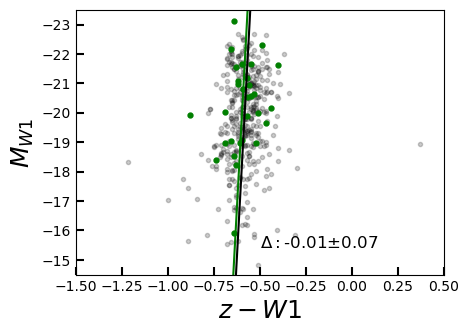

In [33]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0
ax = plt.subplot(gs[p]); p+=1 

ax.plot(C_col, C_w, 'k.', alpha=0.2)
# ax.plot(Z_col, Z_w, 'b.', ms=7)

N = len(C_col)

indx = np.arange(N)
np.random.shuffle(indx)

indx = indx[0:30]

ax.plot(C_col[indx], C_w[indx], 'g.', ms=7)



Z_col = C_col[indx]
Z_w = C_w[indx]
fit, cov = curve_fit(linfit, C_w, C_col)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, '-', color='black')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '-', color='green')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)



ax.set_xlabel(r'$z-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')


[[0.00011411 0.00225914]
 [0.00225914 0.04502758]]
-2.054785587036049 0.21219702426282047
-1.9555174732337959 0.05104015311371841
0.09926811380225309 0.21824911073328074
[[2.51353722e-05 4.97613602e-04]
 [4.97613602e-04 9.91793453e-03]]
-1.2270774721737019 0.09958882735412575
-1.1604998881349426 0.024760369348670184
0.06657758403875924 0.10262071147703289
[[4.13955718e-06 8.19522352e-05]
 [8.19522352e-05 1.63338963e-03]]
-0.4358337325669509 0.04041521527730829
-0.402009655026189 0.01157990414321431
0.03382407754076189 0.04204145342251152
[[2.68466261e-05 5.31491880e-04]
 [5.31491880e-04 1.05931623e-02]]
-3.13651162323991 0.10292308928029247
-3.0913827425706617 0.02712104413372939
0.04512888066924825 0.10643642864124458
[[5.01937579e-06 9.93481178e-05]
 [9.93481178e-05 1.97966222e-03]]
0.14848972352381334 0.04449339526686399
0.17890228521018892 0.01408511836040571
0.030412561686375572 0.04666961304317867


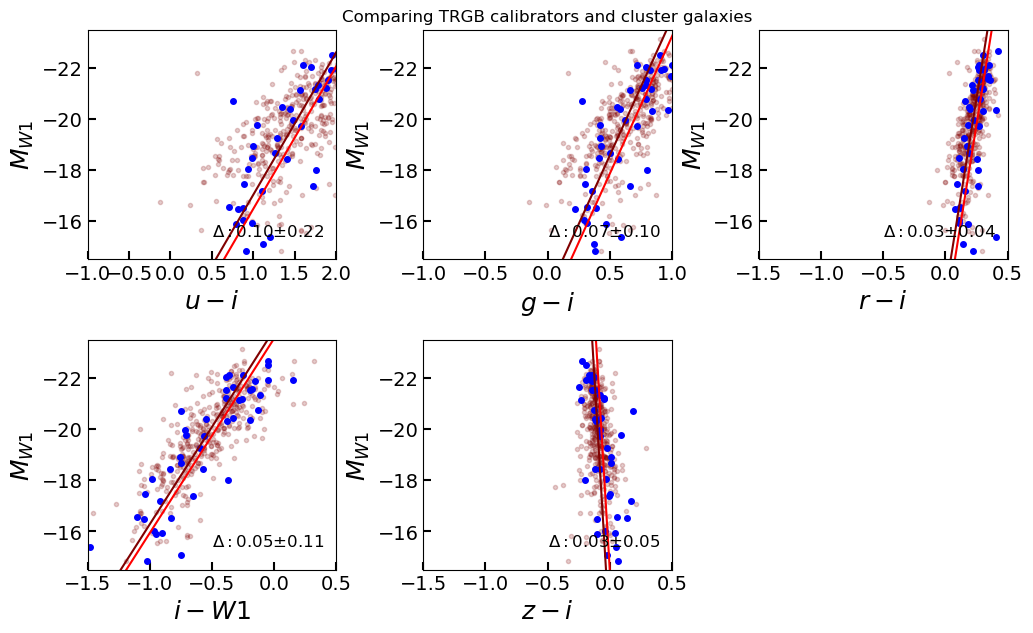

In [34]:
fig = py.figure(figsize=(10, 6), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(2, 3); p=0

##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['u']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['u']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$u-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.0,2.0]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1., 2.5, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['g']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['g']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$g-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.,1.]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1., 1.5, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
plt.title("Comparing TRGB calibrators and cluster galaxies")
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['r']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['r']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$r-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['i']-colorD[key]['w1']
    ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
    C_col.append(i_w1)
    C_w.append(colorD[key]['Mw1'])

Z_col = []
Z_w = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['i']-colorZ[key]['w1']
    ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
    Z_col.append(i_w1)
    Z_w.append(colorZ[key]['Mw1'])


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['z']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['z']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$z-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################



plt.subplots_adjust(hspace=0.35, wspace=0.35)



In [35]:
g_zp = g_zp_calibs['mag']
g_id_zp = g_zp_calibs['pgc']
g_logW = g_zp_calibs['logWimx']
w1_zp = w1_zp_calibs['mag']
w1_id_zp = w1_zp_calibs['pgc']
w1_logW = w1_zp_calibs['logWimx']
for i, id in enumerate(w1_id_zp):
    if id in w1_id_zp:
        indx, = np.where(g_id_zp==id)
        print id, g_id_zp[indx][0], w1_zp[i], g_zp[indx][0], w1_logW [i], g_logW[indx][0]

218 218 9.46 10.14 2.658 2.658
6574 6574 12.17 11.61 2.109 2.109
6595 6595 10.86 10.59 2.323 2.323
6699 6699 13.22 12.33 2.034 2.034
7671 7671 12.18 11.35 1.922 1.922
21396 21396 8.26 8.08 2.454 2.454
22277 22277 14.65 14.01 1.89 1.89
23110 23110 11.76 11.6 2.328 2.328
24930 24930 8.79 9.36 2.631 2.631
26512 26512 8.59 9.34 2.802 2.802
28120 28120 9.81 10.24 2.196 2.196
28357 28357 11.56 12.22 2.454 2.454
28630 28630 6.24 7.11 2.706 2.706
30197 30197 10.26 10.29 2.488 2.488
31671 31671 11.66 11.33 2.34 2.34
32192 32192 8.64 9.49 2.63 2.63
32207 32207 11.7 11.93 2.514 2.514
34695 34695 8.19 8.96 2.605 2.605
37466 37466 11.85 12.01 2.42 2.42
38148 38148 13.12 12.74 1.883 1.883
38688 38688 11.72 10.98 2.177 2.177
39422 39422 10.14 9.47 2.283 2.283
39423 39423 11.15 11.16 2.18 2.18
39600 39600 7.86 8.26 2.652 2.652
40692 40692 9.27 10.36 2.644 2.644
41020 41020 15.43 14.51 1.882 1.882
41066 41066 13.07 12.39 2.072 2.072
41618 41618 9.64 9.54 2.47 2.47
41812 41812 9.64 10.01 2.525 2.525
418

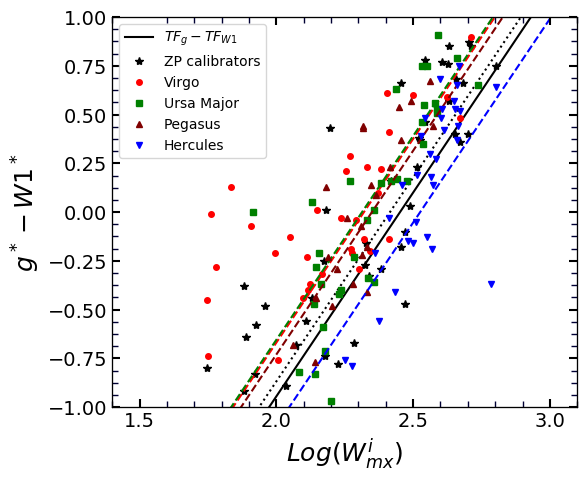

In [36]:
fig, ax = makeFig(band=band, xLim = (1.4,3.1), yLim = (-1,1), MAGabs=True)

wimx = np.linspace(1.5,3, 20)
g_w1 = (-7.37*(wimx-2.5)-20.15-0.11)-(-9.46*(wimx-2.5)-20.36)
g_z = (-7.37*(wimx-2.5)-20.15-0.11)-(-8.44*(wimx-2.5)-20.89-0.08)
r_z = (-7.97*(wimx-2.5)-20.57-0.08)-(-8.44*(wimx-2.5)-20.89-0.08)

ax.plot(wimx, g_w1, 'k-', label=r'$TF_g-TF_{W1}$')


g_zp = g_zp_calibs['mag']
g_id_zp = g_zp_calibs['pgc']
g_logW = g_zp_calibs['logWimx']
w1_zp = w1_zp_calibs['mag']
w1_id_zp = w1_zp_calibs['pgc']
w1_logW = w1_zp_calibs['logWimx']
w1_logWe = w1_zp_calibs['logWimx_e']
wimx_lst = []
wimx_lst_e = []
color_lst = []
for i, id in enumerate(w1_id_zp):
    if id in w1_id_zp:
        indx, = np.where(g_id_zp==id)
        wimx_lst.append(w1_logW[i])
        color_lst.append(g_zp[indx][0]-w1_zp[i])
        wimx_lst_e.append(w1_logWe[i])
    
wimx_lst  = np.asarray(wimx_lst)
wimx_lst_e = np.asarray(wimx_lst_e)
color_lst = np.asarray(color_lst)
ax.plot(wimx_lst, color_lst, '*', color='k', label='ZP calibrators')

slope = 9.46-7.37
fit, cov = curve_fit(linfit_m, color_lst/slope, wimx_lst, sigma=np.sqrt(wimx_lst_e**2+0.01**2))
b = fit[0]
b = -b*slope
x = np.linspace(1.5,3, 20)
ax.plot(x, slope*x+b, ':', color='k')

def funcP(ax, Nest, color='r', label=None, sym='.'):
    
    if label is None:
        label = w1_Clusters[Nest]['code']
    
    w1_pgc = w1_Clusters[Nest]['pgc']
    w1_mag = w1_Clusters[Nest]['mag']
    w1_wimx = w1_Clusters[Nest]['logWimx']
    w1_wimx_e = w1_Clusters[Nest]['logWimx_e']
    g_pgc = g_Clusters[Nest]['pgc']
    g_mag = g_Clusters[Nest]['mag']
    
    wimx_lst = []
    wimx_lst_e = []
    color_lst = []
    for i, idd in enumerate(w1_pgc):
        if idd in g_pgc:
            ix, = np.where(g_pgc==idd)
            wimx_lst.append(w1_wimx[i])
            color_lst.append(g_mag[ix][0]-w1_mag[i])
            wimx_lst_e.append(w1_wimx_e[i])
    
    wimx_lst  = np.asarray(wimx_lst)
    wimx_lst_e = np.asarray(wimx_lst_e)
    color_lst = np.asarray(color_lst)
    
    slope = 9.46-7.37
    fit, cov = curve_fit(linfit_m, color_lst/slope, wimx_lst, sigma=np.sqrt(wimx_lst_e**2+0.01**2))
    b = fit[0]
    b = -b*slope
    
    x = np.linspace(1.5,3, 20)
    ax.plot(x, slope*x+b, '--', color=color)
    
    ax.plot(wimx_lst, color_lst, sym, color=color, label=label, ms=4)
    return wimx_lst, color_lst
        


allW, allC = funcP(ax, 'NEST_100002', 'r', sym='o', label='Virgo')  # Virgo
W, C = funcP(ax, 'NEST_100008', 'g', sym='s', label='Ursa Major')  # Ursa Major
allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))
W, C = funcP(ax, 'NEST_200092', 'maroon', sym='^', label='Pegasus' )  # Pegasus
allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))

W, C = funcP(ax, 'NEST_100007', 'b', sym='v', label='Hercules' )  # Hercules
allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))


ax.set_ylabel(r'$g^*-W1^*} \/\/ [AB]$', fontsize=18) 
ax.legend()
ax.set_xticks(np.arange(1.50, 3.5, step=0.5))

In [37]:
catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx   = table['logWimx']

N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)

for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
    
    
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invali

Using the manual ZP file ... .


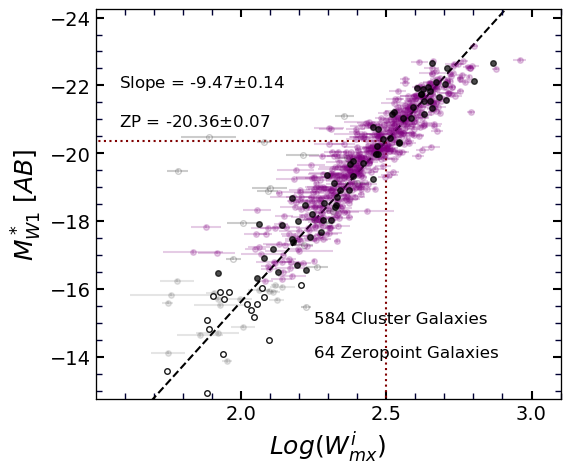

In [38]:
band = 'w1'

fig, ax, w1_Clusters, S_ZP, w1_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=True,
                                            getZPcalib=True,
                                            OP_IR = False,
                                            manualInput=manualInput
                                           )

slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

-0.21204290510861412


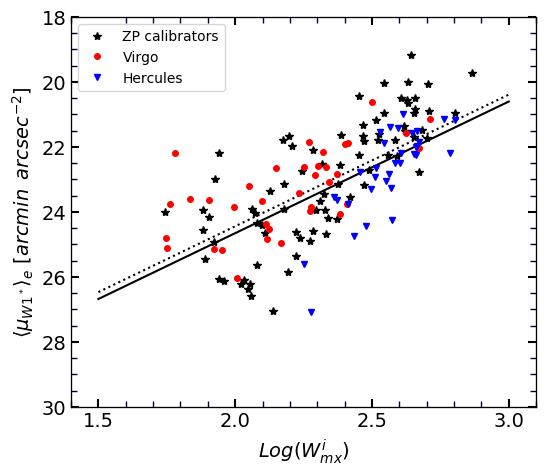

In [39]:
fig, ax = makeFig(band=band, xLim = (1.4,3.1), yLim = (30,18), MAGabs=True)

wimx = np.linspace(1.5,3, 20)
mu_w1 = -4.05*(wimx-2.5)+22.63
ax.plot(wimx, mu_w1, 'k-')


w1_zp = w1_zp_calibs['mag']
w1_id_zp = w1_zp_calibs['pgc']
w1_logW = w1_zp_calibs['logWimx']
w1_logWe = w1_zp_calibs['logWimx_e']
wimx_lst = []
wimx_lst_e = []
color_lst = []
for i, id in enumerate(w1_id_zp):
    if id in pgc_tab:
        indx, = np.where(pgc_tab==id)
        wimx_lst.append(w1_logW[i])
        color_lst.append(mu50_w1[indx][0])
        wimx_lst_e.append(w1_logWe[i])
    
wimx_lst  = np.asarray(wimx_lst)
wimx_lst_e = np.asarray(wimx_lst_e)
color_lst = np.asarray(color_lst)

ax.plot(wimx_lst, color_lst, '*', color='k', label='ZP calibrators')


slope = -4.05
fit, cov = curve_fit(linfit_m, color_lst/slope, wimx_lst, sigma=np.sqrt(wimx_lst_e**2+0.01**2))
b = fit[0]
b = -b*slope
x = np.linspace(1.5,3, 20)
ax.plot(x, slope*x+b, ':', color='k')
print b+2.5*slope-22.63

def funcP(ax, Nest, color='r', label=None, sym='.'):
    
    if label is None:
        label = w1_Clusters[Nest]['code']
    
    w1_pgc = w1_Clusters[Nest]['pgc']
    w1_mag = w1_Clusters[Nest]['mag']
    w1_wimx = w1_Clusters[Nest]['logWimx']
    w1_wimx_e = w1_Clusters[Nest]['logWimx_e']

    
    wimx_lst = []
    wimx_lst_e = []
    color_lst = []
    for i, idd in enumerate(w1_pgc):
        if idd in pgc_tab:
            indx, = np.where(pgc_tab==idd)
            wimx_lst.append(w1_wimx[i])
            color_lst.append(mu50_w1[indx][0])
            wimx_lst_e.append(w1_wimx_e[i])
    
    wimx_lst  = np.asarray(wimx_lst)
    wimx_lst_e = np.asarray(wimx_lst_e)
    color_lst = np.asarray(color_lst)
                 
        
    ax.plot(wimx_lst, color_lst, sym, color=color, label=label, ms=4)
    return wimx_lst, color_lst
        


allW, allC = funcP(ax, 'NEST_100002', 'r', sym='o', label='Virgo')  # Virgo
# W, C = funcP(ax, 'NEST_100008', 'g', sym='s', label='Ursa Major')  # Ursa Major
# allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))
# W, C = funcP(ax, 'NEST_200092', 'maroon', sym='^', label='Pegasus' )  # Pegasus
# allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))

W, C = funcP(ax, 'NEST_100007', 'b', sym='v', label='Hercules' )  # Hercules
allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))


# W, C = funcP(ax, 'NEST_200015', 'cyan', sym='D', label='Fornax' )  # Hercules
# allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))

ax.set_ylabel(r'$\langle \mu_{W1^*} \rangle_e \/\/ [arcmin \/\/\/arcsec^{-2}]$', fontsize=14) 
ax.legend()
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=14)
ax.set_xticks(np.arange(1.50, 3.5, step=0.5))

-40.48963136883615


(<matplotlib.axes._subplots.AxesSubplot at 0x7f24fe23b250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f24fe2f1390>)

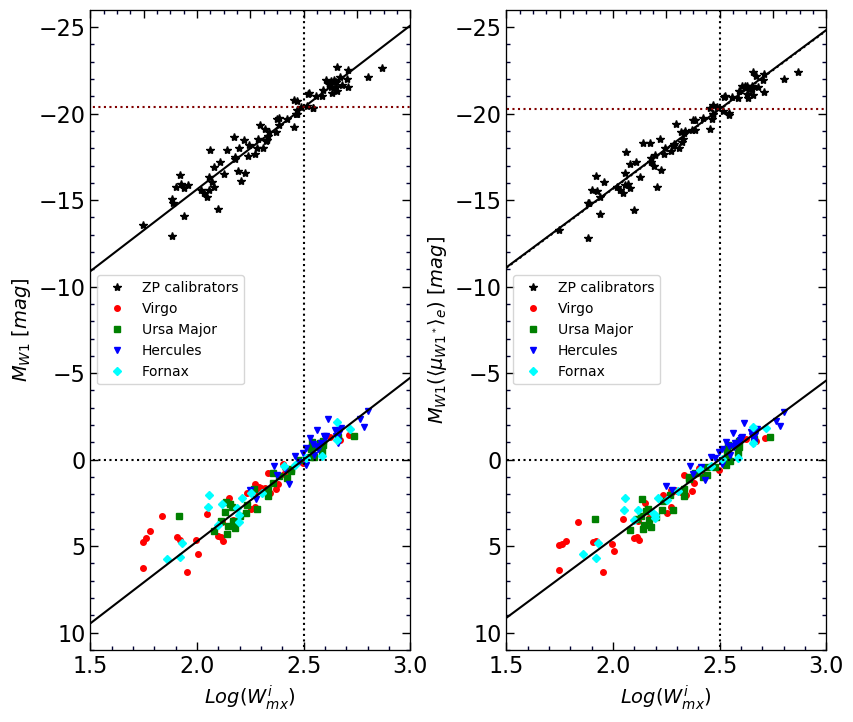

In [40]:
fig = py.figure(figsize=(8,8), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2) ; p=0


ax = plt.subplot(gs[1])
ax0 = plt.subplot(gs[0])


w1_zp = w1_zp_calibs['MAG']
w1_id_zp = w1_zp_calibs['pgc']
w1_logW = w1_zp_calibs['logWimx']
w1_logWe = w1_zp_calibs['logWimx_e']
wimx_lst = []
wimx_lst_e = []
color_lst = []
mag_lst = []
for i, id in enumerate(w1_id_zp):
    if id in pgc_tab:
        indx, = np.where(pgc_tab==id)
        wimx_lst.append(w1_logW[i])
        color_lst.append(mu50_w1[indx][0])
        wimx_lst_e.append(w1_logWe[i])
        mag_lst.append(w1_zp[i])
    
wimx_lst  = np.asarray(wimx_lst)
wimx_lst_e = np.asarray(wimx_lst_e)
color_lst = np.asarray(color_lst)
mag_lst = np.asarray(mag_lst)

D_mu50_w1 = color_lst - (-4.05*(wimx_lst-2.5)+22.63)
magCorrection = -1*(0.16*(D_mu50_w1)-0.05)

ax.plot(wimx_lst, mag_lst+magCorrection, '*', color='k', label='ZP calibrators')
ax0.plot(wimx_lst, mag_lst, '*', color='k', label='ZP calibrators')

slope = -9.15
fit, cov = curve_fit(linfit_m, (mag_lst+magCorrection)/slope, wimx_lst, sigma=np.sqrt(wimx_lst_e**2+0.01**2))
b = fit[0]
b = -b*slope
x = np.linspace(1.5,3, 20)
ax.plot(x, slope*x+b, ':', color='k')
print b+2.5*slope-20.26

def funcP(ax, Nest, color='r', label=None, sym='.'):
    
    if label is None:
        label = w1_Clusters[Nest]['code']
    
    w1_pgc = w1_Clusters[Nest]['pgc']
    w1_mag = w1_Clusters[Nest]['mag']
    w1_wimx = w1_Clusters[Nest]['logWimx']
    w1_wimx_e = w1_Clusters[Nest]['logWimx_e']
    zp_cluster = w1_Clusters[Nest]['zp']

    
    wimx_lst = []
    wimx_lst_e = []
    color_lst = []
    mag_lst = []
    for i, idd in enumerate(w1_pgc):
        if idd in pgc_tab:
            indx, = np.where(pgc_tab==idd)
            wimx_lst.append(w1_wimx[i])
            color_lst.append(mu50_w1[indx][0])
            wimx_lst_e.append(w1_wimx_e[i])
            mag_lst.append(w1_mag[i])
    
    wimx_lst  = np.asarray(wimx_lst)
    wimx_lst_e = np.asarray(wimx_lst_e)
    color_lst = np.asarray(color_lst)
    mag_lst = np.asarray(mag_lst)    
    
    D_mu50_w1 = color_lst - (-4.05*(wimx_lst-2.5)+22.63)
    magCorrection = -1*(0.16*(D_mu50_w1)-0.05)
        
    ax.plot(wimx_lst, mag_lst+magCorrection-zp_cluster, sym, color=color, label=label, ms=4)
    ax0.plot(wimx_lst, mag_lst-zp_cluster, sym, color=color, label=label, ms=4)
    
    return wimx_lst, color_lst
        


allW, allC = funcP(ax, 'NEST_100002', 'r', sym='o', label='Virgo')  # Virgo
W, C = funcP(ax, 'NEST_100008', 'g', sym='s', label='Ursa Major')  # Ursa Major
allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))
# W, C = funcP(ax, 'NEST_200092', 'maroon', sym='^', label='Pegasus' )  # Pegasus
# allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))

W, C = funcP(ax, 'NEST_100007', 'b', sym='v', label='Hercules' )  # Hercules
allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))


W, C = funcP(ax, 'NEST_200015', 'cyan', sym='D', label='Fornax' )  # Fornax
allW=np.concatenate((allW, W)) ; allC=np.concatenate((allC, C))

ax.set_ylabel(r'$ M_{W1}( \langle \mu_{W1^*} \rangle_e) \/\/ [mag]$', fontsize=14) 
ax.legend()
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=14)
ax.set_xticks(np.arange(1.50, 3.5, step=0.5))


wimx = np.linspace(1.5,3, 20)
mu_w1 = -9.15*(wimx-2.5)-20.26
ax.plot(wimx, mu_w1, 'k-')
mu_w1 = -9.15*(wimx-2.5)
ax.plot(wimx, mu_w1, 'k-')

wimx = np.linspace(1.5,3, 20)
mu_w1 = -9.47*(wimx-2.5)-20.36
ax0.plot(wimx, mu_w1, 'k-')
mu_w1 = -9.47*(wimx-2.5)
ax0.plot(wimx, mu_w1, 'k-')


ax.set_ylabel(r'$ M_{W1}( \langle \mu_{W1^*} \rangle_e) \/\/ [mag]$', fontsize=14) 
ax0.set_ylabel(r'$ M_{W1} \/\/ [mag]$', fontsize=14) 
ax.legend() ; ax0.legend()
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=14)
ax0.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=14)
ax.set_xticks(np.arange(1.50, 3.5, step=0.5))
ax.set_ylim(11, -26)
ax0.set_ylim(11, -26)

plt.subplots_adjust(wspace=.3)


ax0.plot([2.5,2.5], [-100,100], 'k:')
ax.plot([2.5,2.5], [-100,100], 'k:')
ax0.plot([-100,100], [0,0], 'k:')
ax.plot([-100,100], [0,0], 'k:')

ax0.plot([-100,100], [-20.36,-20.36], ':', color='maroon')
ax.plot([-100,100], [-20.26,-20.26], ':', color='maroon')

ax.set_xticks(np.arange(1.50, 3.5, step=0.5))
ax0.set_xticks(np.arange(1.50, 3.5, step=0.5))
ax.set_xlim(1.5, 3)
ax0.set_xlim(1.5, 3)

set_axes(ax, (1.5, 3), (11, -26))
set_axes(ax0, (1.5, 3), (11, -26))

In [41]:
for key in w1_Clusters:
    print key

NEST_200092
NEST_200037
NEST_200017
NEST_200005
NEST_200006
NEST_100014
NEST_200003
NEST_100001
NEST_100003
NEST_100002
NEST_100005
NEST_200045
NEST_100007
NEST_100006
NEST_100008
NEST_200016
NEST_100030
NEST_200015
NEST_100018
NEST_200012


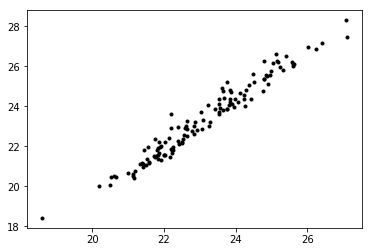

In [42]:
allC_trend = (-7.37*(allW-2.5)-20.15-0.11)-(-9.46*(allW-2.5)-20.36)

plt.plot(allC, allC-allC_trend, 'k.')


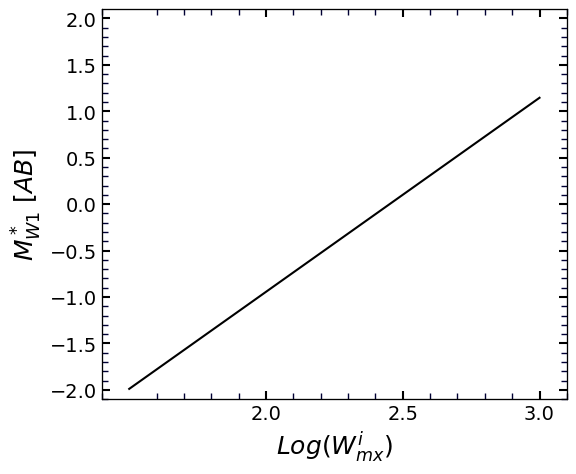

In [43]:
fig, ax = makeFig(band=band, xLim = (1.4,3.1), yLim = (-2.1,2.1), MAGabs=True)

wimx = np.linspace(1.5,3, 20)
g_w1 = (-7.37*(wimx-2.5)-20.15-0.11)-(-9.46*(wimx-2.5)-20.36)
ax.plot(wimx, g_w1, 'k-')

Text(0.1255,1.2,'$2.0<Log( W_{mx}^i)$<2.4')

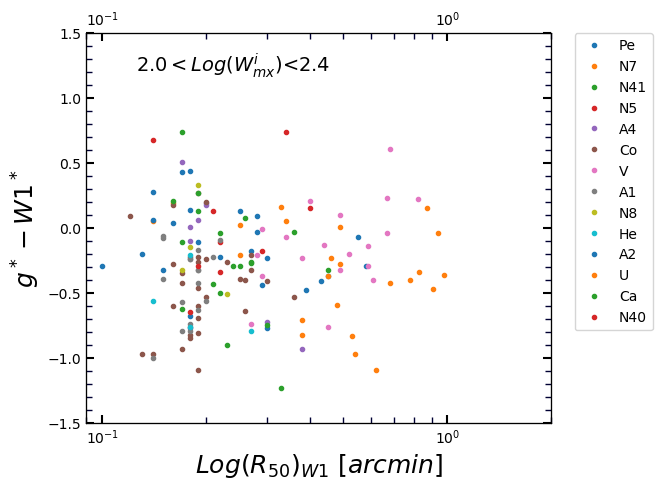

In [44]:
catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']



fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


def funcP(Nest, label=None):
    
    if label is None:
        label = w1_Clusters[Nest]['code']
    
    w1_pgc = w1_Clusters[Nest]['pgc']
    w1_mag = w1_Clusters[Nest]['mag']
    w1_wimx = w1_Clusters[Nest]['logWimx']
    g_pgc = g_Clusters[Nest]['pgc']
    g_mag = g_Clusters[Nest]['mag']
    
    wimx_lst = []
    color_lst = []
    R50_lst = []
    for i, idd in enumerate(w1_pgc):
        if idd in g_pgc:
            ix, = np.where(g_pgc==idd)
            
            wimx = w1_wimx[ix][0]
            
            if wimx>2.0 and wimx<2.4:
            
                color_lst.append(g_mag[ix][0]-w1_mag[i])
                wimx_lst.append(wimx)

                indx, = np.where(pgc_catal==idd)
                R50   = R50w1_catal[indx][0]
                R50_lst.append(R50)

            
    
    wimx_lst  = np.asarray(wimx_lst)
    color_lst = np.asarray(color_lst)
    R50_lst = np.asarray(R50_lst)

    ax.plot(R50_lst, color_lst, '.',  label=label)
        


# funcP( 'NEST_100002')  # Virgo
# funcP( 'NEST_100008')  # Ursa Major
# funcP( 'NEST_200092')  # Pegasus
# funcP( 'NEST_100007')  # Hercules

for key in i_Clusters:
    funcP(key)

ax.set_ylabel(r'$g^*-W1^*} \/\/ [AB]$', fontsize=18) 
ax.set_xlabel(r'$Log(R_{50})_{W1} \/\/[arcmin]$', fontsize=18) 

ax.set_xscale('log')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xlim(0.09,2)
ax.set_ylim(-1.5,1.5)


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(Ylm)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        
    
    
if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(Xlm)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in') 
    x_ax.set_xscale('log')

    
x0 = 0.95*Xlm[0]+0.02*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, r'$2.0<Log( W_{mx}^i)$<2.4', fontsize=14, color='k')